# 📉 Unit 2.2: Exponential Smoothing (ETS)

**Course:** Advanced Machine Learning (AICC 303)  
**Topics:**
*   Simple Exponential Smoothing (SES)
*   Double Exponential Smoothing (Holt's Trend)
*   Triple Exponential Smoothing (Holt-Winters Seasonal)
*   State Space Models & Model Selection (AIC)

**Reference:** Hyndman & Athanasopoulos, *Forecasting: Principles and Practice*, Chapter 3.

While ARIMA focuses on autocorrelations, **Exponential Smoothing** focuses on weighted averages of past observations, with weights decaying exponentially as observations get older.

---

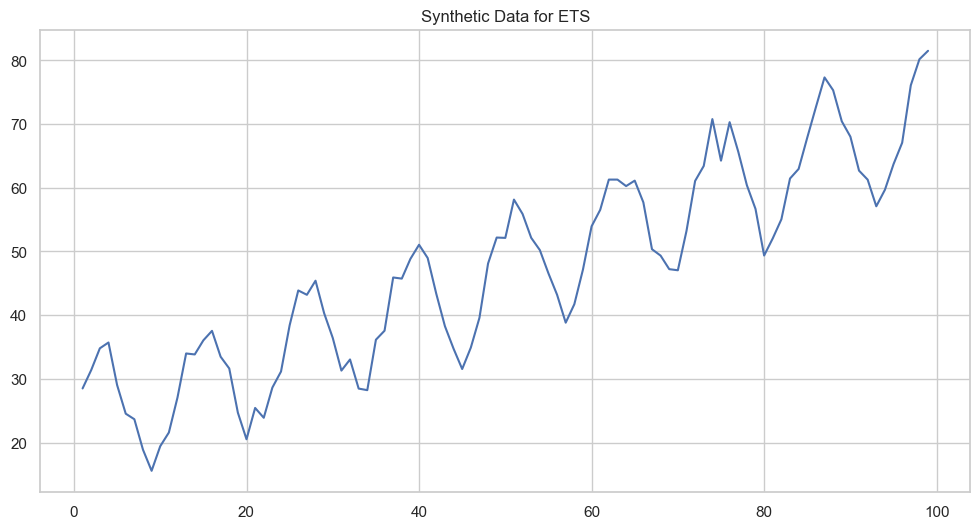

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

# Setup
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Generate Synthetic Data (Linear Trend + Multiplicative Seasonality)
np.random.seed(42)
t = np.arange(1, 100)
trend = 0.5 * t
seasonality = 10 * np.sin(2 * np.pi * t / 12) + 12 # Period 12
noise = np.random.normal(0, 2, len(t))

y = trend + seasonality + noise
# Make it strictly positive for Multiplicative models
y = np.abs(y) + 10 

df = pd.DataFrame({'Time': t, 'Value': y})
df.set_index('Time', inplace=True)

plt.plot(df['Value'])
plt.title("Synthetic Data for ETS")
plt.show()

## 1. Simple Exponential Smoothing (SES)

Suitable for data with **no trend** and **no seasonality**.
$$ \hat{y}_{t+1|t} = \alpha y_t + (1-\alpha) \hat{y}_{t|t-1} $$
where $0 \le \alpha \le 1$ is the smoothing parameter.

*   $\alpha \to 1$: Weighs recent data heavily (Naive).
*   $\alpha \to 0$: Weighs past data heavily (Mean).

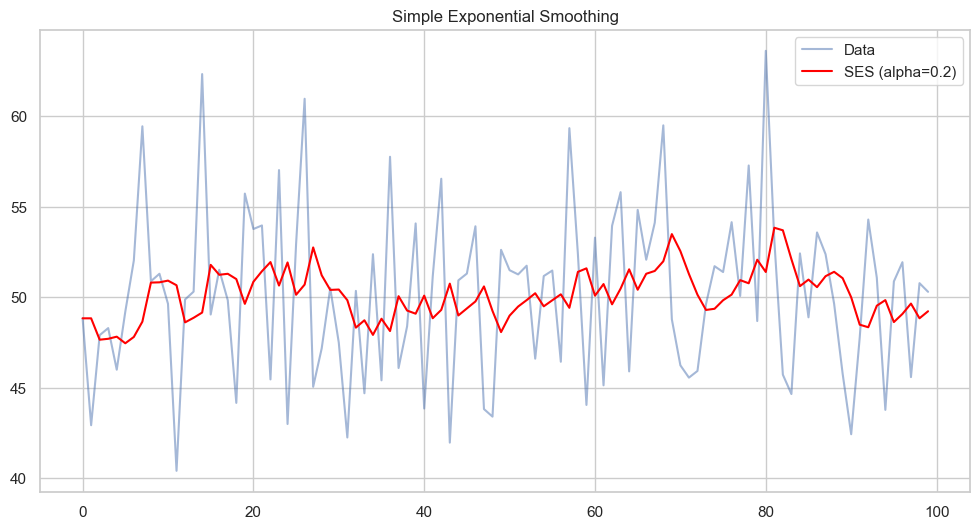

In [2]:
# Example on a flat subset of data (just noise)
flat_data = np.random.normal(50, 5, 100)

model_ses = SimpleExpSmoothing(flat_data)
fit_ses = model_ses.fit(smoothing_level=0.2, optimized=False)

plt.plot(flat_data, label='Data', alpha=0.5)
plt.plot(fit_ses.fittedvalues, label='SES (alpha=0.2)', color='red')
plt.title("Simple Exponential Smoothing")
plt.legend()
plt.show()

## 2. Double Exponential Smoothing (Holt's Linear Trend)

Extends SES to handle **Trend**.
It maintains two equations:
1.  **Level ($l_t$):** The baseline value.
2.  **Trend ($b_t$):** The slope.

Forecast: $\hat{y}_{t+h|t} = l_t + h b_t$

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


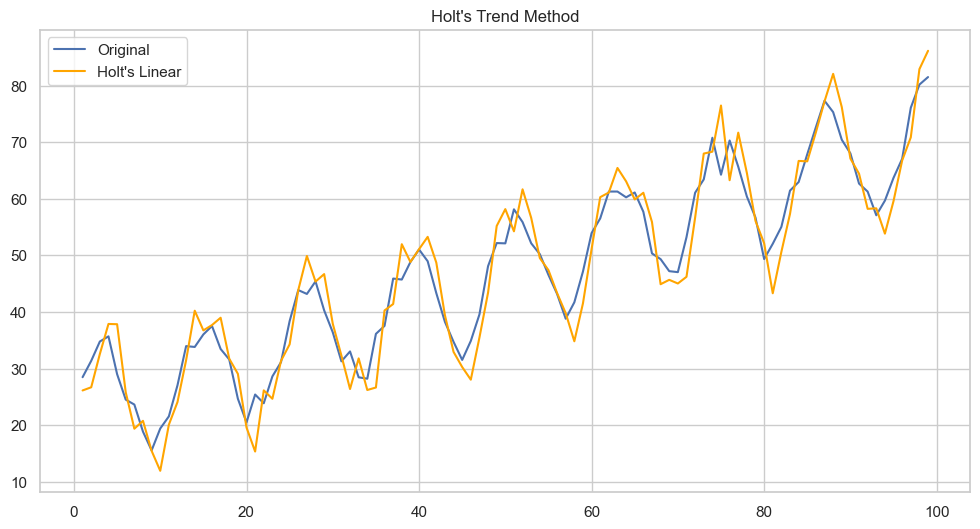

In [3]:
# Fit on our trended data
# 'add' means Additive Trend
model_holt = ExponentialSmoothing(df['Value'], trend='add', seasonal=None)
fit_holt = model_holt.fit()

plt.plot(df['Value'], label='Original')
plt.plot(fit_holt.fittedvalues, label='Holt\'s Linear', color='orange')
plt.title("Holt's Trend Method")
plt.legend()
plt.show()

## 3. Holt-Winters Seasonal Method (Triple Smoothing)

Adds a third component: **Seasonality** ($s_t$).
Two variations:
1.  **Additive Method:** Seasonality is constant amplitude ($y_t = l_t + b_t + s_t$).
2.  **Multiplicative Method:** Seasonality changes proportional to level ($y_t = (l_t + b_t) \times s_t$).

**Parameters:**
*   $\alpha$: Smoothing for Level
*   $\beta$: Smoothing for Trend
*   $\gamma$: Smoothing for Seasonality

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


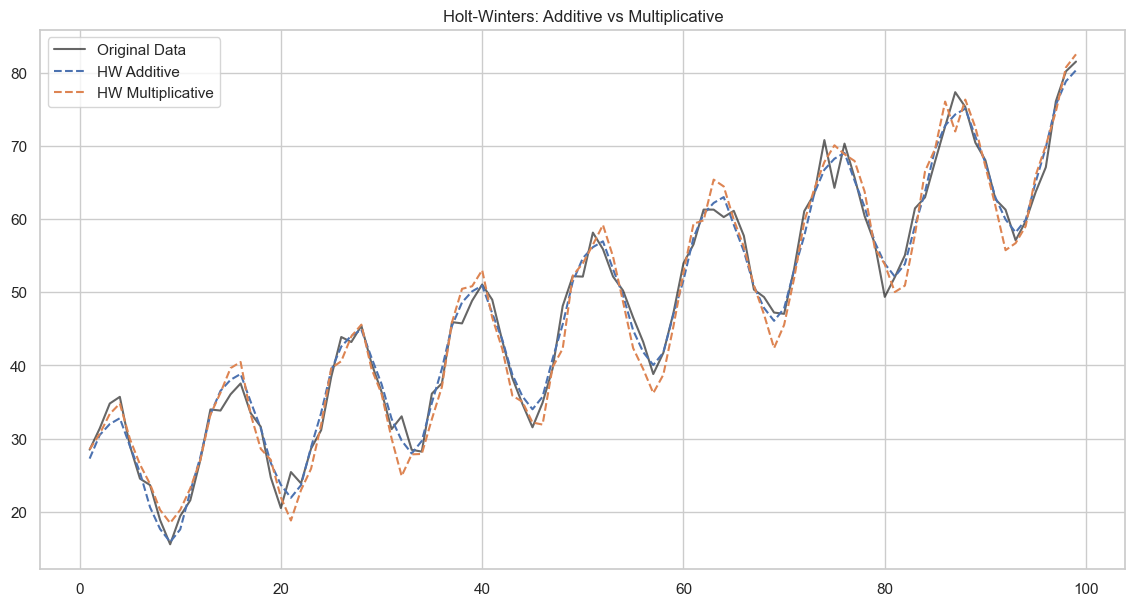

In [4]:
# Fit Holt-Winters
# seasonal_periods=12 (Monthly)
model_hw_add = ExponentialSmoothing(df['Value'], 
                                    trend='add', 
                                    seasonal='add', 
                                    seasonal_periods=12).fit()

model_hw_mul = ExponentialSmoothing(df['Value'], 
                                    trend='add', 
                                    seasonal='mul', 
                                    seasonal_periods=12).fit()

plt.figure(figsize=(14, 7))
plt.plot(df['Value'], label='Original Data', color='black', alpha=0.6)
plt.plot(model_hw_add.fittedvalues, label='HW Additive', linestyle='--')
plt.plot(model_hw_mul.fittedvalues, label='HW Multiplicative', linestyle='--')
plt.title("Holt-Winters: Additive vs Multiplicative")
plt.legend()
plt.show()

## 4. State Space Models & Model Selection

Hyndman categorizes ETS models based on their Error, Trend, and Seasonal components:
**ETS(Error, Trend, Seasonal)**
*   **Error:** Additive (A), Multiplicative (M)
*   **Trend:** None (N), Additive (A), Additive Damped (Ad), etc.
*   **Seasonal:** None (N), Additive (A), Multiplicative (M)

**Example:** ETS(A, A, A) is Holt-Winters Additive Method with Additive Errors.

### Automatic Selection (AIC)
The `statsmodels` library calculates the AIC (Akaike Information Criterion) for the fitted model. Lower AIC indicates a better balance of fit and complexity.

Additive Model AIC: 138.70
Multiplicative Model AIC: 224.33
Best Model based on AIC: Additive


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


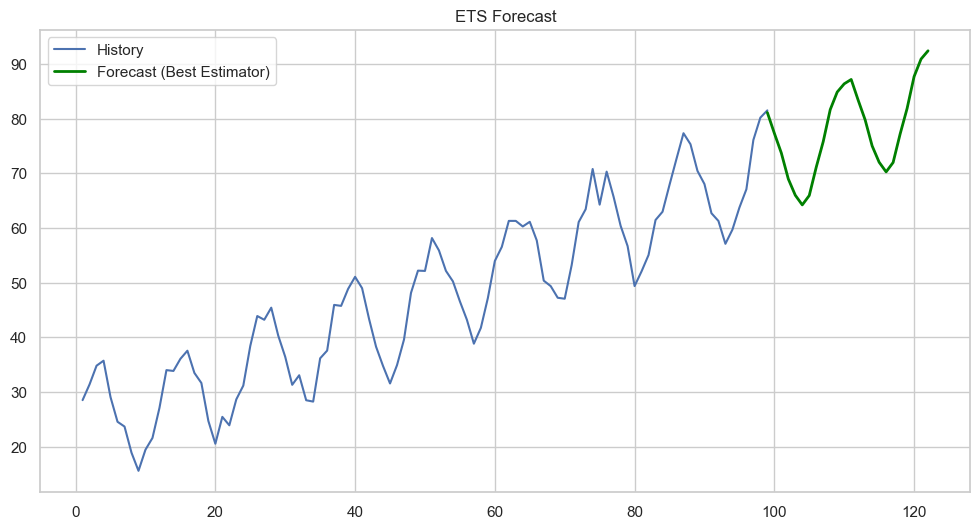

In [5]:
print(f"Additive Model AIC: {model_hw_add.aic:.2f}")
print(f"Multiplicative Model AIC: {model_hw_mul.aic:.2f}")

best_model = model_hw_add if model_hw_add.aic < model_hw_mul.aic else model_hw_mul
print(f"Best Model based on AIC: {'Additive' if best_model == model_hw_add else 'Multiplicative'}")

# Forecast Future
forecast = best_model.forecast(steps=24)

plt.figure(figsize=(12, 6))
plt.plot(df['Value'], label='History')
plt.plot(forecast, label='Forecast (Best Estimator)', color='green', linewidth=2)
plt.title("ETS Forecast")
plt.legend()
plt.show()

### 5. Damped Trend
If a linear trend persists indefinitely, forecasts can become unrealistic. **Damped** trend gradually reduces the trend to a flat line.
Useful for long-term forecasting.

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-

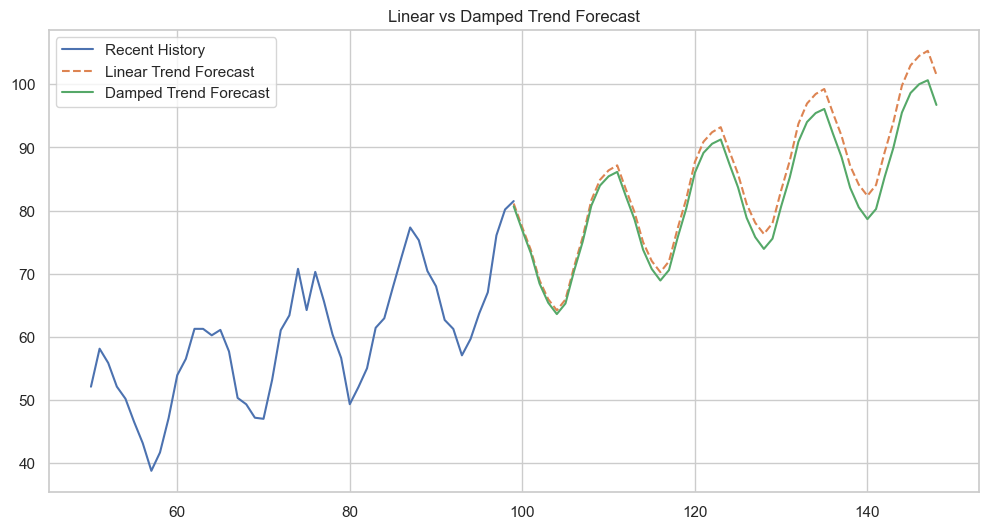

In [6]:
model_damped = ExponentialSmoothing(df['Value'], 
                                    trend='add', 
                                    damped_trend=True, 
                                    seasonal='add', 
                                    seasonal_periods=12).fit()

forecast_damped = model_damped.forecast(steps=50)
forecast_linear = model_hw_add.forecast(steps=50)

plt.figure(figsize=(12, 6))
plt.plot(df['Value'].iloc[-50:], label='Recent History')
plt.plot(forecast_linear, label='Linear Trend Forecast', linestyle='--')
plt.plot(forecast_damped, label='Damped Trend Forecast')
plt.title("Linear vs Damped Trend Forecast")
plt.legend()
plt.show()